In [ ]:
#Para uma explicação detalhada sobre esse projeto, visite 
#meu portfolio em: https://henriquelucasdf.github.io/post/projeto3/

# 0.0 Configurações iniciais

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 0.1 Imports

In [2]:
!pip install fbprophet
!pip install optuna

     |████████████████████████████████| 266kB 12.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 163kB 26.2MB/s 
     |████████████████████████████████| 81kB 10.3MB/s 
     |████████████████████████████████| 81kB 10.3MB/s 
     |████████████████████████████████| 112kB 28.9MB/s 
     |████████████████████████████████| 133kB 14.0MB/s 
     |████████████████████████████████| 51kB 4.8MB/s 
  Created wheel for optuna: filename=optuna-2.3.0-cp36-none-any.whl size=359761 sha256=026b042fe67357dfd3062f21aaf9dc69ea4239617b4f130ff1c0f443399b11bd
  Stored in directory: /root/.cache/pip/wheels/fa/91/19/64b0ec6b964f89c0695a9dc6db6f851d0b54c5381a5c9cadfb
Successfully built optuna
  Created wheel for PrettyTable: filename=prettytable-0.7.2-cp36-none-any.whl size=13700 sha256=afe0f038a45fa8179637b8724d245c4d4b8f4ac232d763b192cdc2fa842d594f
  Stored in directory: /root/.cache/pip/

In [3]:
import pandas as pd
import numpy as np
import datetime
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsa_plots

from IPython.display import Image
from IPython.core.display import display, HTML


from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from fbprophet.diagnostics import cross_validation, performance_metrics

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error

import optuna 
from optuna import Trial, visualization
from optuna.samplers import TPESampler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 0.2 Funções

In [4]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set() 
    
jupyter_settings()


def mean_absolute_percentage_error(y, yhat):
  y, yhat = np.array(y), np.array(yhat)
  return np.mean(np.abs((y - yhat) / y))

def ml_error (model_name, y, yhat):
  mae = mean_absolute_error(y,yhat)
  mape = mean_absolute_percentage_error(y,yhat) 
  r2 = r2_score(y,yhat)
  rmse = np.sqrt(mean_squared_error(y,yhat))

  return pd.DataFrame({ 'Model Name': model_name,
                       'MAE': mae,
                       'MAPE': mape,
                       'R2': r2,
                       'RMSE': rmse}, index = [0],
                      )



Populating the interactive namespace from numpy and matplotlib


# 1.0 Análise Inicial dos dados

### 1.1 Carregando os dados

In [5]:
df_raw1 = pd.read_excel('/content/drive/My Drive/data_science/repos/previsao_vendas_morana/dados/vendas_vendedor.xlsx')
df_raw2 = pd.read_excel('/content/drive/My Drive/data_science/repos/previsao_vendas_morana/dados/vendas_vendedor2.xlsx')
df_raw3 = pd.read_excel('/content/drive/My Drive/data_science/repos/previsao_vendas_morana/dados/vendas_vendedor3.xlsx')

### 1.2 Descrição dos dados:

In [6]:
print('df1:', df_raw1.shape)
print('df2:', df_raw2.shape)
print('df3:', df_raw3.shape)

print("Data inicial:", df_raw1.data.min())
print("Data final:", df_raw3.data.max())

df1: (65534, 22)
df2: (65534, 22)
df3: (65365, 23)
Data inicial: 2014-01-02 00:00:00
Data final: 2020-10-31 00:00:00


### 1.3 Unindo os DataFrames

In [7]:
df1 = pd.concat([df_raw1, df_raw2, df_raw3], ignore_index=True)
df1.shape

(196433, 23)

### 1.4 Retirando dados duplicados

In [8]:
df1 = df1.drop_duplicates()

### 1.5 Retirando colunas desnecessárias


In [9]:
df1.sample()

,vendedor,data,idcupom,operador,cupom,caixa,tipo,produto,nomeproduto,qtde,valorb,descontos,acrescimos,valorl,vlrbascom,dtinicio,dtfim,comissao,vlrcomissao,rede,filial,nomeloja,Unnamed: 22
128545,VENDA DIRETA-000113400000,2018-06-28,0001134280620180000140001,1,14,1,V,5409120762,PULSEIRA 00128 C/BASES LISAS,1,79.9,0.0,0.0,79.9,79.9,2016-06-01,2020-10-25,0,0,1,134,MORANA TAGUATINGA,NaN


In [10]:
#Uma abordagem univariada será utilizada pois as outras colunas não possuem valor preditivo
df1 = df1[['data','tipo', 'vlrbascom']].copy()

### 1.6 Tipos de dados

In [11]:
df1.dtypes

data         datetime64[ns]
tipo                 object
vlrbascom           float64
dtype: object

### 1.7 Checando NAs

In [12]:
df1.isna().sum()
#nenhum NaN

data         0
tipo         0
vlrbascom    0
dtype: int64

#2.0 Preparação dos Dados

In [13]:
df2 = df1.copy()

In [14]:
#Apenas as vendas serão utilizadas
df2 = df2[df2['tipo']=='V']

#Retirando essa coluna:
df2.drop(columns='tipo', inplace=True)

In [15]:
#2 conjuntos de dados serão utilizados: um contendo dados diários e outro contendo dados semanais
#Agrupando em dados diários:
df2_dia = df2.groupby('data').sum().reset_index()

#agrupando em dados semanais: 
df2_aux = df2_dia.copy()
df2_aux.set_index('data', inplace=True)
df2_sem = df2_aux.resample('1W').sum().reset_index()

In [16]:
#Renomeando as colunas
df2_dia.columns = ['data', 'vendas_dia']

df2_sem.columns = ['data', 'vendas_sem']

# 3.0 Análise Exploratória de Dados

In [17]:
df3_dia = df2_dia.copy()
df3_sem = df2_sem.copy()

In [ ]:
#@title 3.1 Estatística descritiva (clique 2x no título para visualizar o código)

stats = np.round(pd.DataFrame([df3_dia['vendas_dia'].describe()
            ,df3_sem['vendas_sem'].describe()]).T, decimals=2)

stats.columns = ["Vendas Diárias", "Vendas Semanais"]
stats.index = ["Itens", "Média", "Desvio Padrão","Mínimo",
         "1º Quartil", "Mediana","2º Quartil", "Máximo"]

stats

,Vendas Diárias,Vendas Semanais
Itens,2351.00,357.00
Média,4508.88,29692.93
Desvio Padrão,3800.34,19818.30
Mínimo,59.90,0.00
1º Quartil,2350.25,21411.80
Mediana,3424.00,25469.60
2º Quartil,5363.95,31400.00
Máximo,36687.00,158247.55


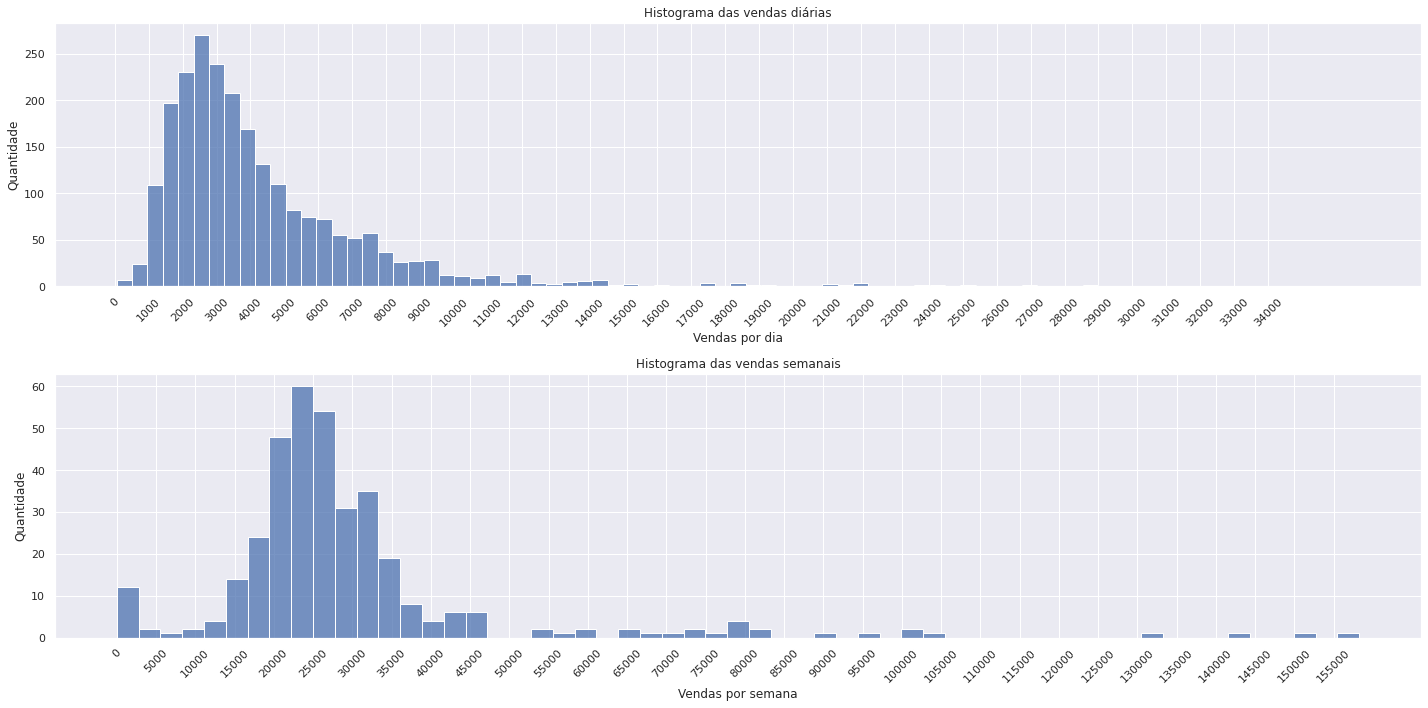

In [ ]:
#@title 3.2 Histograma das vendas 
plt.subplot(2,1,1)
sns.histplot(df3_dia['vendas_dia'])
plt.title("Histograma das vendas diárias")
plt.ylabel("Quantidade")
plt.xlabel("Vendas por dia")
plt.xticks(np.arange(0,35000,1000),rotation=45);

plt.subplot(2,1,2)
sns.histplot(df3_sem['vendas_sem'])
plt.title("Histograma das vendas semanais")
plt.ylabel("Quantidade")
plt.xlabel("Vendas por semana")
plt.xticks(np.arange(0,160000,5000),rotation=45)
plt.tight_layout()

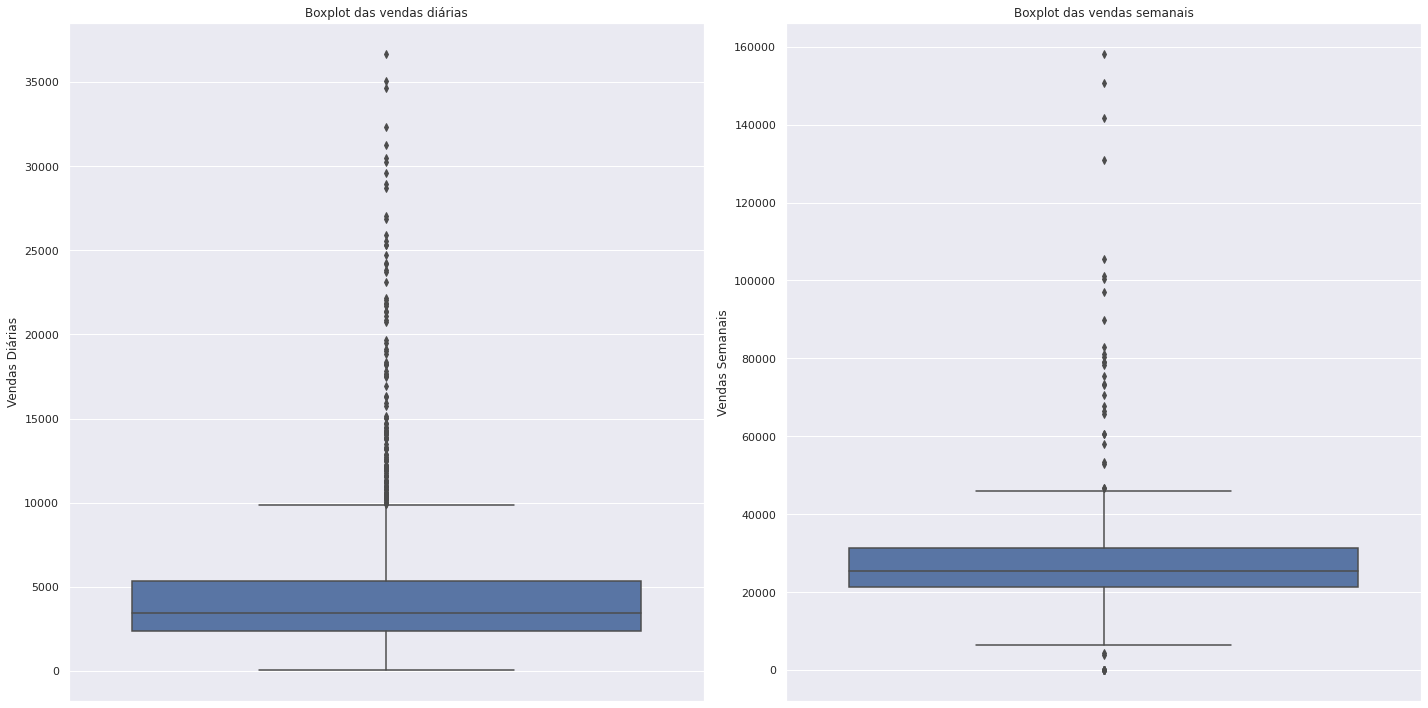

In [ ]:
#@title 3.3 Boxplots

plt.subplot(1,2,1)
sns.boxplot(y= df3_dia['vendas_dia'])
plt.ylabel("Vendas Diárias")
plt.title("Boxplot das vendas diárias")


plt.subplot(1,2,2)
sns.boxplot(y = df3_sem['vendas_sem'])
plt.ylabel("Vendas Semanais")
plt.title("Boxplot das vendas semanais")

plt.tight_layout();

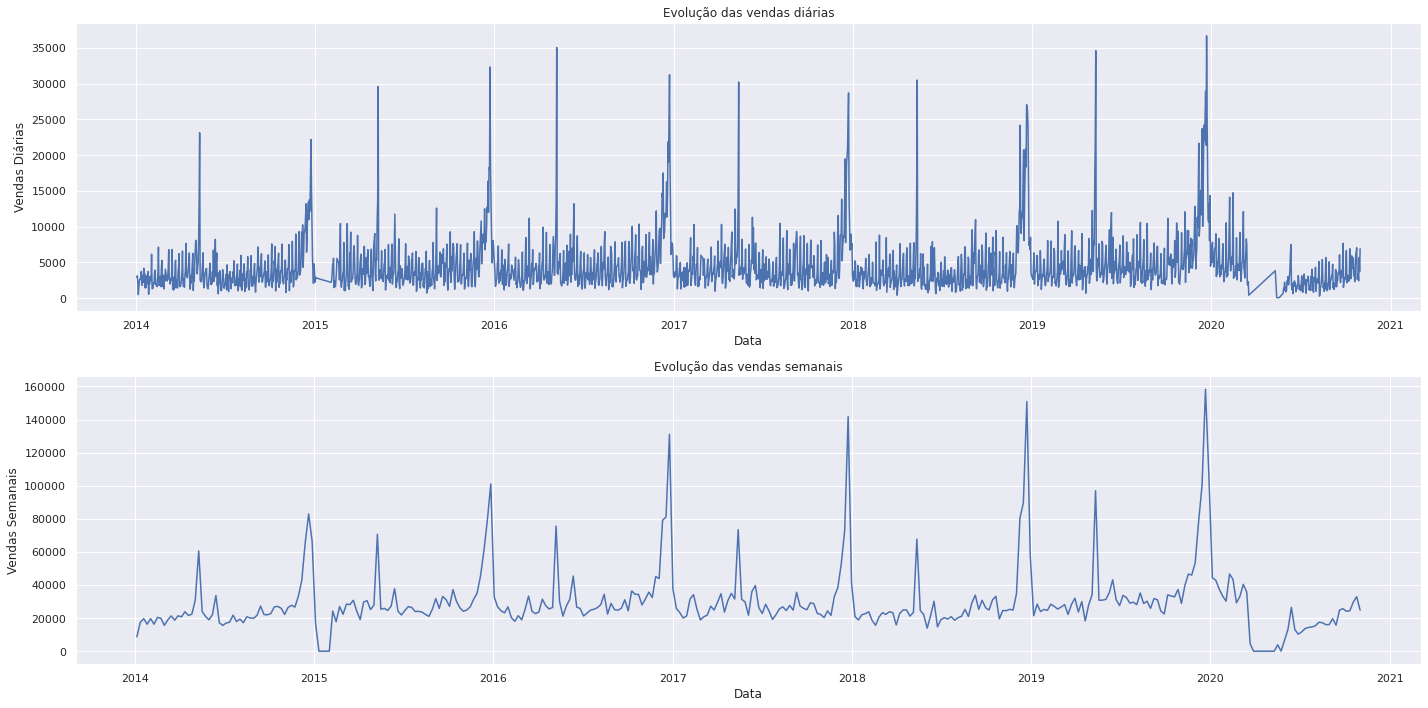

In [ ]:
#@title 3.4 Evolução das vendas

plt.subplot(2,1,1)
sns.lineplot(x='data', y='vendas_dia', data=df3_dia)
plt.ylabel("Vendas Diárias")
plt.xlabel("Data")
plt.title("Evolução das vendas diárias")


plt.subplot(2,1,2)
sns.lineplot(x='data', y='vendas_sem', data=df3_sem)
plt.ylabel("Vendas Semanais")
plt.xlabel("Data")
plt.title("Evolução das vendas semanais")

plt.tight_layout()

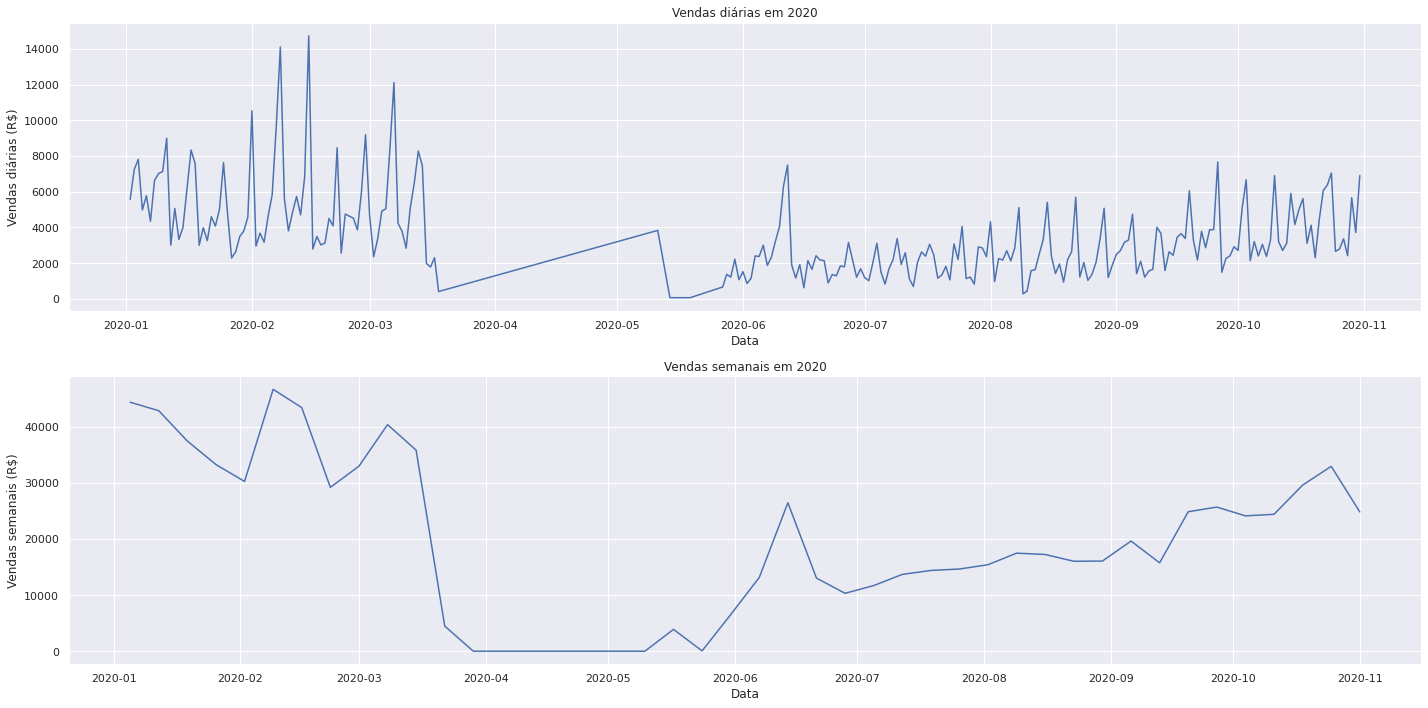

In [ ]:
#@title 3.5 Vendas em 2020
vendas_dia_20 = df3_dia[df3_dia['data']>='2020-01-01']
vendas_sem_20 = df3_sem[df3_sem['data']>='2020-01-01']

plt.subplot(2,1,1)
sns.lineplot(x='data', y='vendas_dia', data=vendas_dia_20)
plt.title("Vendas diárias em 2020")
plt.ylabel("Vendas diárias (R$)")
plt.xlabel("Data")

plt.subplot(2,1,2)
sns.lineplot(x='data', y='vendas_sem', data=vendas_sem_20)
plt.title("Vendas semanais em 2020")
plt.ylabel("Vendas semanais (R$)")
plt.xlabel("Data")

plt.tight_layout()

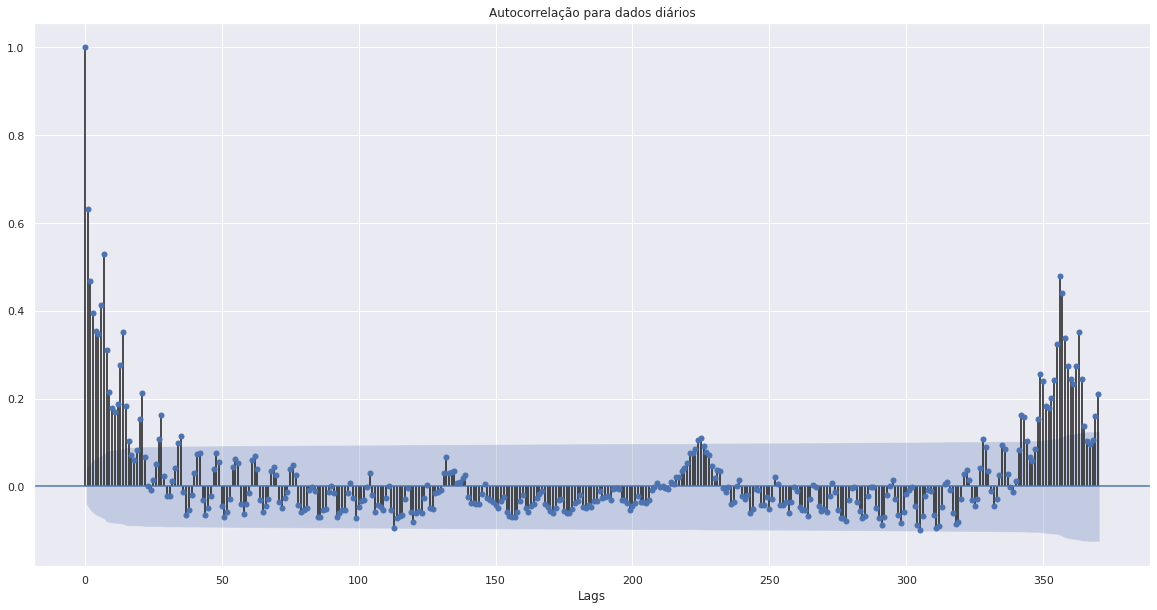

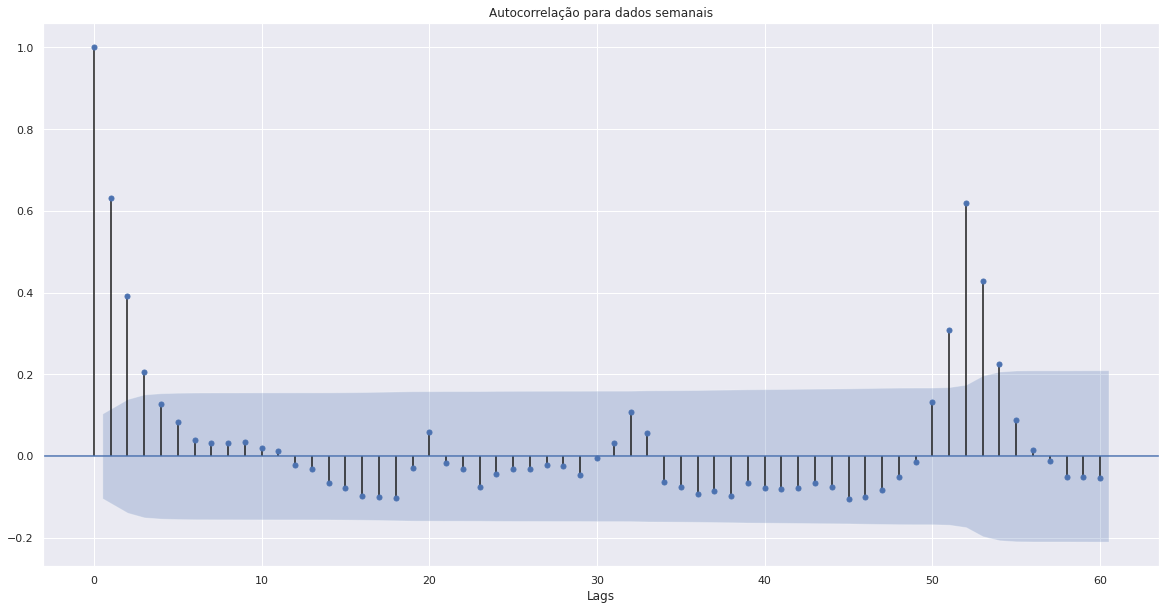

<Figure size 1440x720 with 0 Axes>

In [ ]:
#@title 3.6 Gráficos de autocorrelação

#Colocando a data no index: 
df3_diaux = df3_dia.set_index('data')
df3_semaux = df3_sem.set_index('data')


tsa_plots.plot_acf(df3_diaux, lags=370)
plt.title("Autocorrelação para dados diários")
plt.xlabel("Lags")
plt.show();


tsa_plots.plot_acf(df3_semaux, lags=60)
plt.title( "Autocorrelação para dados semanais")
plt.xlabel("Lags")
plt.show();

plt.tight_layout();

# 4.0 Feature Engineering

In [18]:
df4_dia = df3_dia.copy()
df4_sem = df3_sem.copy()

### 4.1 Transformação das vendas

In [19]:
#tornar a série mais bem comportada - 2 formas: log e elevar a 1/3
df4_diaux = df4_dia.copy()
df4_semaux = df4_sem.copy()

df4_diaux['log_dia'] = np.log1p(df4_diaux['vendas_dia'])
df4_diaux['exp_dia'] = df4_diaux['vendas_dia']**(1/3)

df4_semaux['log_sem'] = np.log1p(df4_semaux['vendas_sem'])
df4_semaux['exp_sem'] = df4_semaux['vendas_sem']**(1/3)

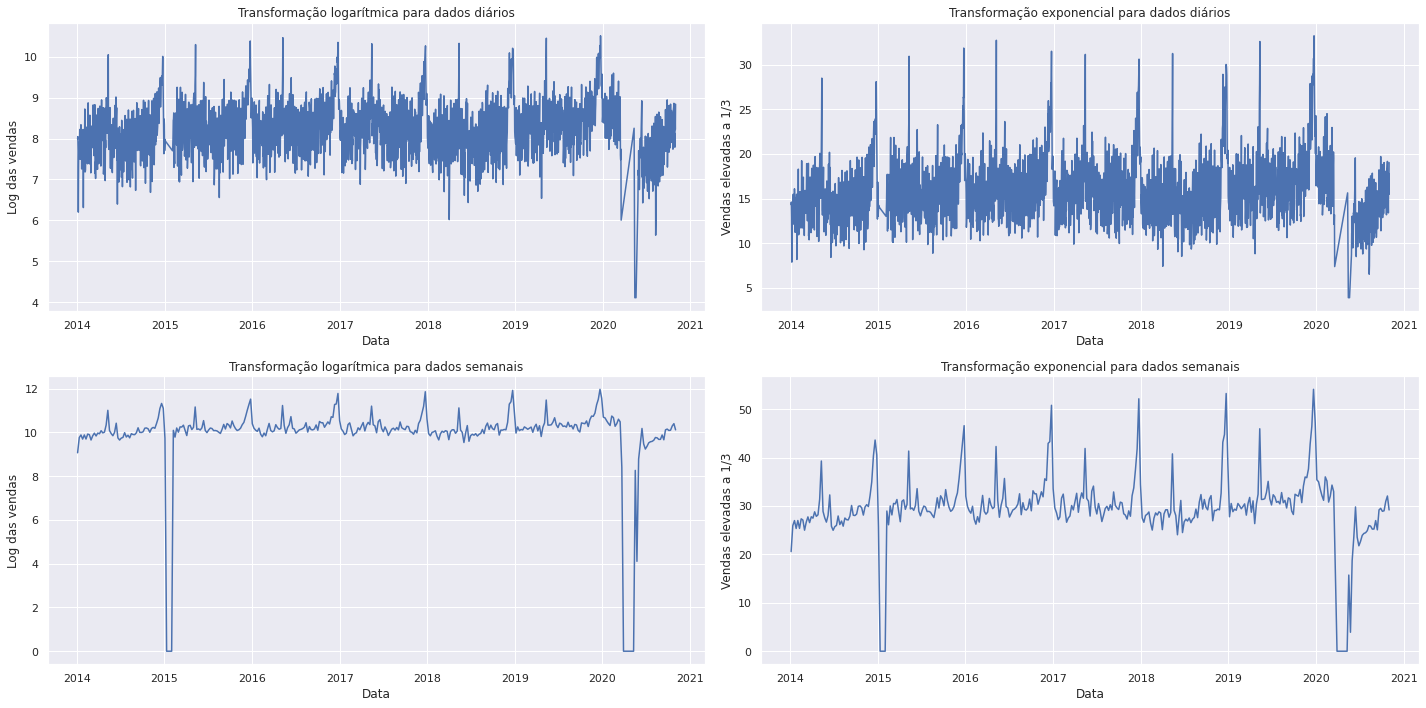

In [20]:
#@title Qual transformação escolher? 
plt.subplot(2,2,1)
sns.lineplot(x='data', y='log_dia', data=df4_diaux)
plt.title("Transformação logarítmica para dados diários")
plt.ylabel("Log das vendas")
plt.xlabel("Data")

plt.subplot(2,2,2)
sns.lineplot(x='data', y='exp_dia', data=df4_diaux)
plt.title("Transformação exponencial para dados diários")
plt.ylabel("Vendas elevadas a 1/3")
plt.xlabel("Data")

plt.subplot(2,2,3)
sns.lineplot(x='data', y='log_sem', data=df4_semaux)
plt.title("Transformação logarítmica para dados semanais")
plt.ylabel("Log das vendas")
plt.xlabel("Data")

plt.subplot(2,2,4)
sns.lineplot(x='data', y='exp_sem', data=df4_semaux)
plt.title("Transformação exponencial para dados semanais")
plt.ylabel("Vendas elevadas a 1/3")
plt.xlabel("Data")

plt.tight_layout()


In [21]:
#Usar a transformação logaritmica
df4_dia['vendas_dia'] = np.log1p(df4_dia['vendas_dia'])
df4_sem['vendas_sem'] = np.log1p(df4_sem['vendas_sem'])

### 4.2 Separação em treino e teste

In [22]:
#Usar setembro e outubro como teste
df4_dia_treino = df4_dia[df4_dia['data']<'2020-09-01']
df4_dia_teste = df4_dia[df4_dia['data']>='2020-09-01']

df4_sem_treino = df4_sem[df4_sem['data']<'2020-09-01']
df4_sem_teste = df4_sem[df4_sem['data']>='2020-09-01']

### 4.3 Retirando outliers

In [23]:
#Dropando valores nulos e NaNs para dados diários
#df4_dia_treino.sort_values('vendas_dia').head(10)

#Apenas o valor dos dias 2020-05-14
df4_dia_treino.drop(index=[2192,2193], inplace=True)
                    
#Dropando outliers para dados semanais
#df4_sem_treino.sort_values('vendas_sem').head(15)


df4_sem_treino = df4_sem_treino[df4_sem_treino['vendas_sem']>0]
df4_sem_treino.drop(index=[324,332,333,334], inplace=True)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# 5.0 Elaboração do Modelo de Machine Learning

In [24]:
#Preparando os dados: 
df5_dia_treino = df4_dia_treino.copy()
df5_dia_teste = df4_dia_teste.copy()

df5_sem_treino = df4_sem_treino.copy()
df5_sem_teste = df4_sem_teste.copy()

In [25]:
#Renomeando as colunas
df5_dia_treino.columns = ['ds','y']
df5_dia_teste.columns = ['ds','y']

df5_sem_treino.columns = ['ds','y']
df5_sem_teste.columns = ['ds','y']

## 5.1 Modelo para vendas diárias

#### 5.1.1 Definindo os feriados:

In [ ]:
#Feriado de natal:
natal_dia = pd.DataFrame({
  'holiday': 'Natal',
  'ds': pd.to_datetime(['2020-12-23','2019-12-23', '2018-12-23',
                        '2017-12-23','2016-12-23','2015-12-23']),
  'lower_window': -23,
  'upper_window': 8 })

#Feriado dia das mães:
maes_dia = pd.DataFrame({
   'holiday': 'dia_maes',
   'ds': pd.to_datetime(['2020-05-10','2019-05-12','2017-05-14',
                         '2018-05-13','2016-05-08', '2015-05-10']),
   'lower_window': -10,
   'upper_window': 10})

holidays_dia = pd.concat((natal_dia,maes_dia))

#### 5.1.2 Definindo e treinando o modelo

In [ ]:
modelo_dia = Prophet(holidays = holidays_dia, holidays_prior_scale = 1,
                     seasonality_mode='multiplicative', seasonality_prior_scale = 0.001,
                     changepoint_range=0.9, changepoint_prior_scale=0.5,
                     daily_seasonality=False, weekly_seasonality = False, 
                     yearly_seasonality = False).add_seasonality(
                         name = 'monthly',
                         period = 30.5,
                         fourier_order=55
                     ).add_seasonality(
                         name = 'weekly',
                         period = 7,
                         fourier_order=15
                     ).add_seasonality(
                         name = 'yearly',
                         period = 365.25,
                         fourier_order = 20
                     )

#Treinando
random.seed(1)
modelo_dia.fit(df5_dia_treino)

#### 5.1.3 Fazendo as previsões

In [ ]:
future_dia = modelo_dia.make_future_dataframe(periods = 62, freq = 'D')
forecast_dia = modelo_dia.predict(future_dia)

#### 5.1.4 Visualizando 

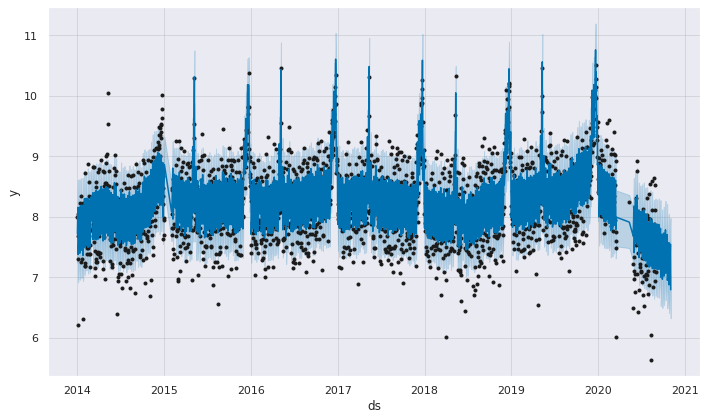

In [ ]:
 #Visualizando as previsões
 fig1_dia = modelo_dia.plot(forecast_dia)

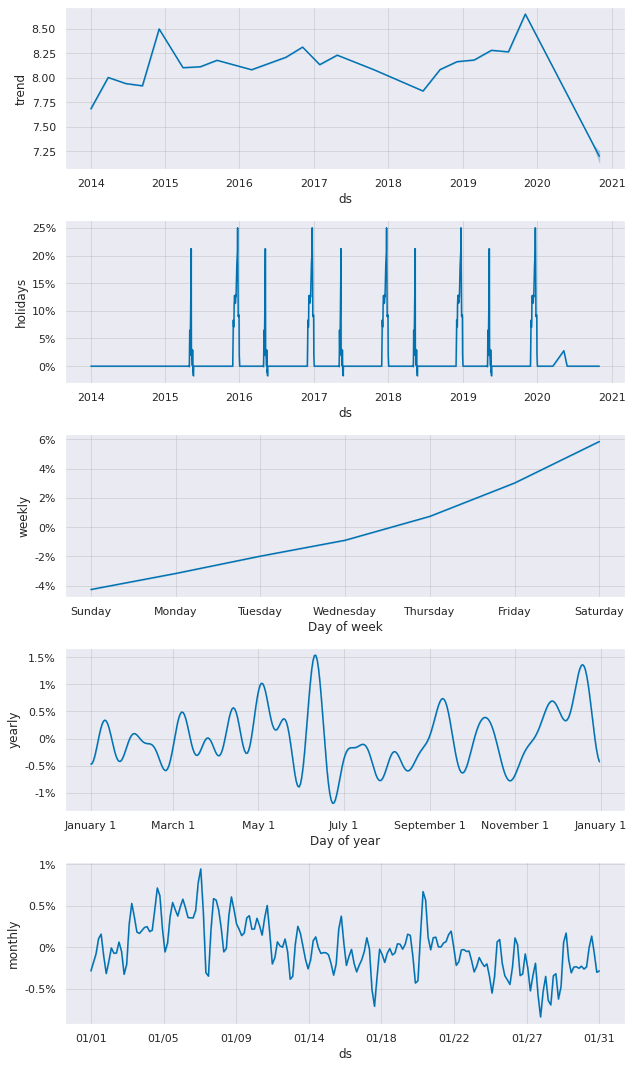

In [ ]:
#Visualizando os componentes
fig2_dia = modelo_dia.plot_components(forecast_dia)

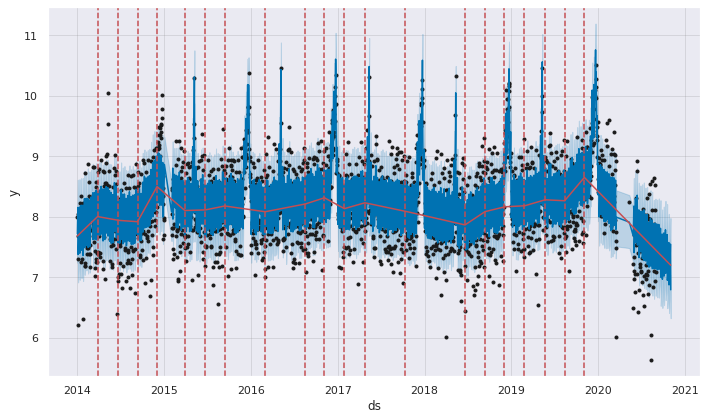

In [ ]:
#Visualização dos changepoints
fig3_dia = modelo_dia.plot(forecast_dia)
a = add_changepoints_to_plot(fig3_dia.gca(), modelo_dia, forecast_dia)

#### 5.1.5 Cross validation 

In [ ]:
random.seed(1)
cutoffs = pd.to_datetime(['2016-03-01','2016-11-1','2017-03-01','2017-11-01',
                          '2018-03-01','2018-11-01', '2019-03-01', '2019-11-01'])
df_cv_dia = cross_validation(modelo_dia, horizon = '62 D', cutoffs=cutoffs, parallel="processes")

INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fee17368160>


In [ ]:
#Voltando os dados para a grandeza original
cv_dia = df_cv_dia.copy()
cv_dia['yhat'] = np.expm1(cv_dia['yhat'])
cv_dia['yhat_lower'] = np.expm1(cv_dia['yhat_lower'])
cv_dia['yhat_upper'] = np.expm1(cv_dia['yhat_upper'])
cv_dia['y'] = np.expm1(cv_dia['y'])

In [ ]:
#Visualizando a performance
df_p_dia = performance_metrics(cv_dia)
ml_error("Prophet Inicial Diário", np.expm1(df_cv_dia['y']), np.expm1(df_cv_dia['yhat']))

,Model Name,MAE,MAPE,R2,RMSE
0,Prophet Inicial Diário,1808.089327,0.299324,0.725923,2918.843241


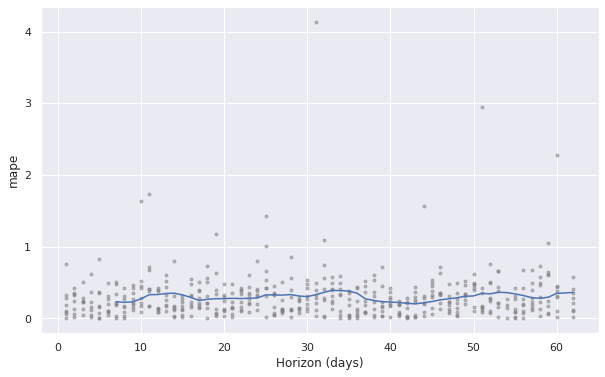

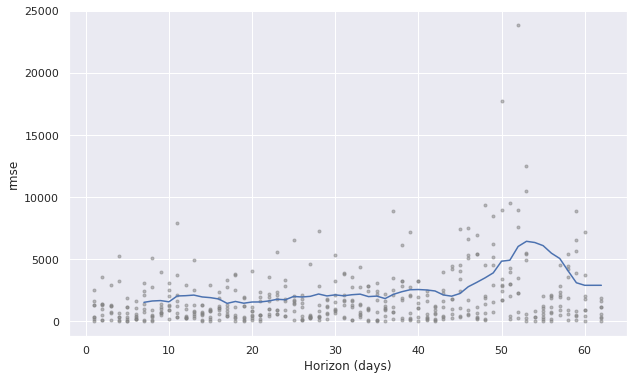

In [ ]:
figmape = plot_cross_validation_metric(cv_dia, metric='mape')
figrmse = plot_cross_validation_metric(cv_dia, metric='rmse')

## 5.2 Modelo para vendas semanais

### 5.2.1 Dias de feriado: natal e dia das mães para vendas semanais

In [ ]:
#Feriados para dados semanais
natal = pd.DataFrame({
  'holiday': 'Natal',
  'ds': pd.to_datetime(['2020-12-27','2019-12-22', '2018-12-23','2017-12-24','2016-12-25','2015-12-27','2014-12-21']),
  'lower_window': -3,
  'upper_window': 2 })
#'2014-12-25','2015-12-25','2016-12-25','2017-12-25','2018-12-25','2019-12-25', '2020-12-25'
maes = pd.DataFrame({
   'holiday': 'dia_maes',
   'ds': pd.to_datetime(['2020-05-17','2019-05-12','2017-05-14','2018-05-13','2016-05-08', '2015-05-10', '2014-05-11']),
   'lower_window': -3,
   'upper_window': 2})

holidays_sem = pd.concat((natal,maes))

### 5.2 Definindo e Treinando o Modelo

In [ ]:
modelo_sem = Prophet(holidays = holidays_sem, holidays_prior_scale = 40,
                        seasonality_mode='multiplicative', seasonality_prior_scale = 5,
                        changepoint_range= 0.9, changepoint_prior_scale = 0.05,
                        daily_seasonality=False, weekly_seasonality = False, 
                        yearly_seasonality = False).add_seasonality(
                          name = 'monthly',
                          period = 30.5,
                          fourier_order=10
                      ).add_seasonality(
                          name = 'weekly',
                          period = 7,
                          fourier_order=15
                      ).add_seasonality(
                          name = 'yearly',
                          period = 365.25,
                          fourier_order = 20
                      )

#Treinando
random.seed(1)
modelo_sem.fit(df5_sem_treino)

### 5.2.3 Previsões

In [ ]:
#Prevendo
future_sem = modelo_sem.make_future_dataframe(periods = 9, freq = 'W')
forecast_sem = modelo_sem.predict(future_sem)

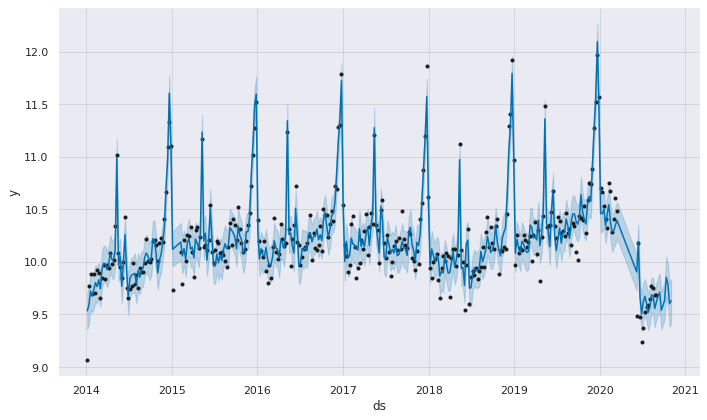

In [ ]:
 #Visualizando as previsões
 fig1 = modelo_sem.plot(forecast_sem)

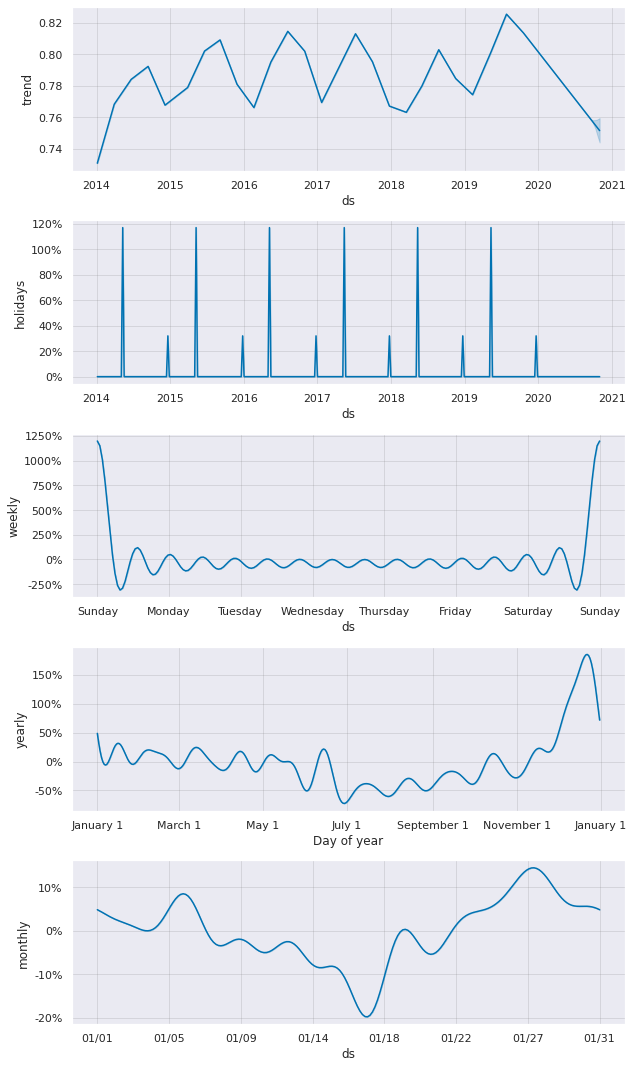

In [ ]:
#Visualizando os componentes
fig2 = modelo_sem.plot_components(forecast_sem)

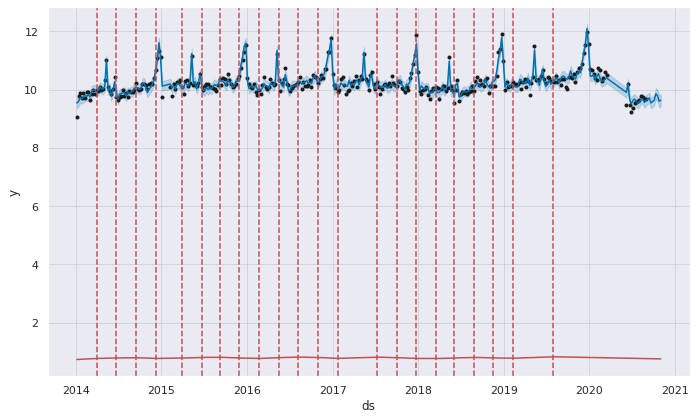

In [ ]:
#Visualização dos changepoints
fig3 = modelo_sem.plot(forecast_sem)
a = add_changepoints_to_plot(fig3.gca(), modelo_sem, forecast_sem)

### 5.2.4 Cross validation 

In [ ]:
random.seed(1)
cutoffs = pd.to_datetime(['2016-03-01','2016-11-1','2017-03-01','2017-11-01',
                          '2018-03-01','2018-11-01', '2019-03-01', '2019-11-01'])
df_cv_sem = cross_validation(modelo_sem, horizon = '9 W', cutoffs=cutoffs, parallel="processes")

INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff4192a63c8>


In [ ]:
#Voltando os dados para a grandeza original
cv = df_cv_sem.copy()
cv['yhat'] = np.expm1(cv['yhat'])
cv['yhat_lower'] = np.expm1(cv['yhat_lower'])
cv['yhat_upper'] = np.expm1(cv['yhat_upper'])
cv['y'] = np.expm1(cv['y'])

In [ ]:
#Visualizando a performance
df_p = performance_metrics(cv)

In [ ]:
ml_error("Prophet semanal", np.expm1(df_cv_sem['y']), np.expm1(df_cv_sem['yhat']))

,Model Name,MAE,MAPE,R2,RMSE
0,Prophet semanal,7759.812556,0.207759,0.882261,10942.523926


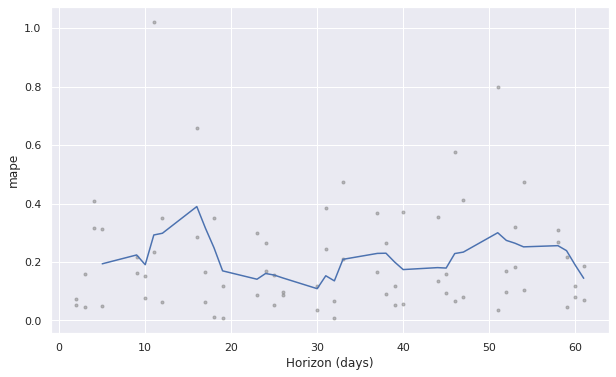

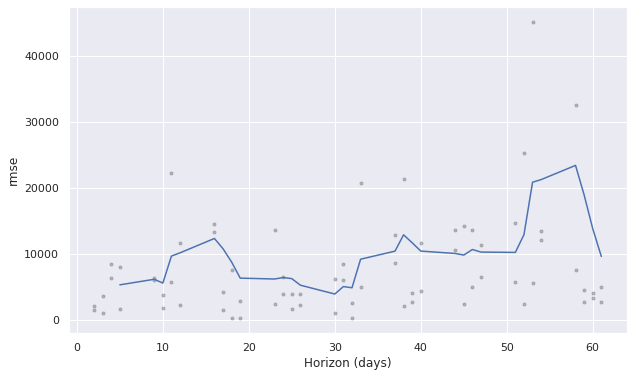

In [ ]:
figmape = plot_cross_validation_metric(cv, metric='mape')
figrmse = plot_cross_validation_metric(cv, metric='rmse')

# 6.0 Tuning dos Hiperparâmetros

- O modelo de vendas semanais apresentou melhor performance. Será escolhido para realizar as previsões.
- A biblioteca optuna será utilizada para realizar o tuning dos hiperparâmetros

### 6.1 Definindo a otimização

In [ ]:
def otimiza_params(trial):

  changepoint_prior_scale = trial.suggest_loguniform('changepoint_prior_scale', 0.045, 0.07)
  seasonality_prior_scale = trial.suggest_loguniform('seasonality_prior_scale', 4, 9 )
  holidays_prior_scale = trial.suggest_uniform('holidays_prior_scale', 35, 45)
  changepoint_range = trial.suggest_uniform('changepoint_range', 0.89, 0.95)
  lower_window_natal = trial.suggest_int('lower_window_natal', -15, 0)
  upper_window_natal = trial.suggest_int('upper_window_natal', 0, 15)
  lower_window_maes =  trial.suggest_int('lower_window_maes', -15, 0)
  upper_window_maes = trial.suggest_int('upper_window_maes', 0, 15)
  fourier_order_mes = trial.suggest_int('fourier_order_mes', 8, 20)
  fourier_order_sem = trial.suggest_int('fourier_order_sem', 10, 20)
  fourier_order_ano = trial.suggest_int('fourier_order_ano', 15, 30)
  
  #Feriados para dados semanais
  natal = pd.DataFrame({
      'holiday': 'Natal',
      'ds': pd.to_datetime(['2020-12-27','2019-12-22', '2018-12-23','2017-12-24','2016-12-25','2015-12-27','2014-12-21']),
      'lower_window': lower_window_natal,
      'upper_window': upper_window_natal })

  maes = pd.DataFrame({
      'holiday': 'dia_maes',
      'ds': pd.to_datetime(['2020-05-17','2019-05-12','2017-05-14','2018-05-13','2016-05-08', '2015-05-10', '2014-05-11']),
      'lower_window': lower_window_maes,
      'upper_window': upper_window_maes})

  holidays_sem = pd.concat((natal,maes))
  random.seed(1)
  modelo_sem_tuned = Prophet(holidays = holidays_sem, 
                        holidays_prior_scale = holidays_prior_scale,
                        seasonality_mode='multiplicative',
                        seasonality_prior_scale = seasonality_prior_scale,
                        changepoint_range= changepoint_range,
                        changepoint_prior_scale= changepoint_prior_scale,
                        daily_seasonality=False, 
                        weekly_seasonality = False, 
                        yearly_seasonality = False
                      ).add_seasonality(
                          name = 'monthly',
                          period = 30.5,
                          fourier_order=fourier_order_mes
                      ).add_seasonality(
                          name = 'weekly',
                          period = 7,
                          fourier_order=fourier_order_sem
                      ).add_seasonality(
                          name = 'yearly',
                          period = 365.25,
                          fourier_order = fourier_order_ano
                      )

  #Treinando
  random.seed(1)
  modelo_sem_tuned.fit(df5_sem_treino)
 
  #Cross-Validation
  cutoffs = pd.to_datetime(['2016-03-01','2016-11-1','2017-03-01','2017-11-01',
                            '2018-03-01','2018-11-01', '2019-03-01', '2019-11-01'])
  random.seed(1)
  df_cv_sem = cross_validation(modelo_sem_tuned, horizon = '9 W', cutoffs=cutoffs, parallel="processes")

  
  #Voltando os dados para a grandeza original
  cv = df_cv_sem.copy()
  cv['yhat'] = np.expm1(cv['yhat'])
  cv['yhat_lower'] = np.expm1(cv['yhat_lower'])
  cv['yhat_upper'] = np.expm1(cv['yhat_upper'])
  cv['y'] = np.expm1(cv['y'])

  #RMSE
  
  return mean_squared_error(cv['y'],cv['yhat'])


### 6.2 Otimizando

In [ ]:
#Otimizando:
random.seed(1)
sampler = optuna.samplers.TPESampler()
study = optuna.create_study(direction='minimize',sampler=sampler)
random.seed(1)
study.optimize(otimiza_params, n_trials= 250)

[I 2020-11-29 16:14:58,974] A new study created in memory with name: no-name-1d1e2ea8-ff68-4602-acc6-3d3651d7da50
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa14e853438>
[I 2020-11-29 16:15:13,301] Trial 0 finished with value: 164432943.08110952 and parameters: {'changepoint_prior_scale': 0.06061438940720386, 'seasonality_prior_scale': 5.047999039414394, 'holidays_prior_scale': 40.51322249009009, 'changepoint_range': 0.9326102134239661, 'lower_window_natal': -4, 'upper_window_natal': 1, 'lower_window_maes': -7, 'upper_window_maes': 4, 'fourier_order_mes': 13, 'fourier_order_sem': 13, 'fourier_order_ano': 29}. Best is trial 0 with value: 164432943.08110952.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa152ef72e8>
[I 2020-11-29 16:15:28,529] Trial 1 finished with value: 178290813.5174678 and parameters: {'changepoint_prior_scale': 0.06231790244862668, 'seasonality_prior_sc

In [ ]:
#Melhores parâmetros
print('Best trial: score {},\nparams {}'.format(study.best_trial.value,study.best_trial.params))

Best trial: score 9056.711716961081,
params {'changepoint_prior_scale': 0.04637131084737127, 'seasonality_prior_scale': 8.41238910871876, 'holidays_prior_scale': 42.83477585390071, 'changepoint_range': 0.9238153132520232, 'lower_window_natal': -10, 'upper_window_natal': 9, 'lower_window_maes': -4, 'upper_window_maes': 10, 'fourier_order_mes': 8, 'fourier_order_sem': 16, 'fourier_order_ano': 27}


### 6.3 Visualizando a otimização

In [ ]:
#Visualizando
visualization.plot_optimization_history(study)

### 6.4 Melhor modelo

In [ ]:
#Feriados otimizados

natal = pd.DataFrame({
      'holiday': 'Natal',
      'ds': pd.to_datetime(['2020-12-27','2019-12-22', '2018-12-23','2017-12-24','2016-12-25','2015-12-27','2014-12-21']),
      'lower_window': -10,
      'upper_window': 9 })

maes = pd.DataFrame({
      'holiday': 'dia_maes',
      'ds': pd.to_datetime(['2020-05-17','2019-05-12','2017-05-14','2018-05-13','2016-05-08', '2015-05-10', '2014-05-11']),
      'lower_window': -4,
      'upper_window': 10})

holidays_otim = pd.concat((natal,maes))

In [ ]:
random.seed(1)
modelo_otim = Prophet(holidays = holidays_otim, 
                        holidays_prior_scale = 42.83477585390071,
                        seasonality_mode='multiplicative',
                        seasonality_prior_scale = 8.41238910871876,
                        changepoint_range= 0.9238153132520232,
                        changepoint_prior_scale= 0.04637131084737127,
                        daily_seasonality=False, 
                        weekly_seasonality = False, 
                        yearly_seasonality = False
                      ).add_seasonality(
                          name = 'monthly',
                          period = 30.5,
                          fourier_order=8
                      ).add_seasonality(
                          name = 'weekly',
                          period = 7,
                          fourier_order=16
                      ).add_seasonality(
                          name = 'yearly',
                          period = 365.25,
                          fourier_order = 27
                      )


In [ ]:
#Treinando
random.seed(1)
modelo_otim.fit(df5_sem_treino)
 
  #Cross-Validation
cutoffs = pd.to_datetime(['2016-03-01','2016-11-1','2017-03-01','2017-11-01',
                            '2018-03-01','2018-11-01', '2019-03-01', '2019-11-01'])
random.seed(1)
df_cv_sem = cross_validation(modelo_otim, horizon = '8 W', cutoffs=cutoffs, parallel="processes")

  
  #Voltando os dados para a grandeza original
cv = df_cv_sem.copy()
cv['yhat'] = np.expm1(cv['yhat'])
cv['yhat_lower'] = np.expm1(cv['yhat_lower'])
cv['yhat_upper'] = np.expm1(cv['yhat_upper'])
cv['y'] = np.expm1(cv['y'])

  #RMSE
ml_error("Prophet semanal",cv['y'], cv['yhat'])

INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa14e8ad5c0>


,Model Name,MAE,MAPE,R2,RMSE
0,Prophet semanal,6746.303254,0.197412,0.923576,9012.310463


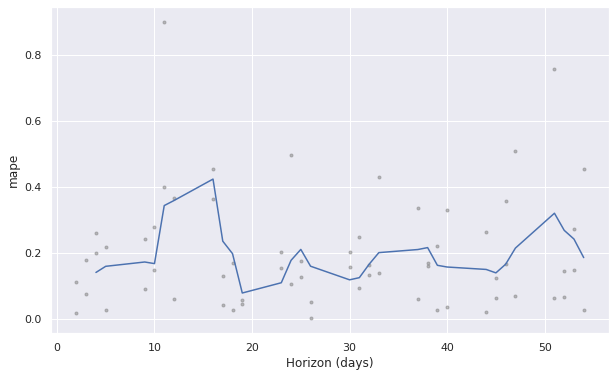

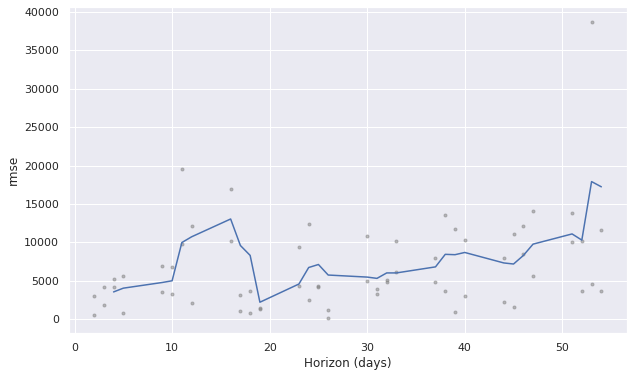

In [ ]:
figmape = plot_cross_validation_metric(cv, metric='mape')
figrmse = plot_cross_validation_metric(cv, metric='rmse')

#### 6.4.1 Previsões

In [ ]:
#Prevendo
future_sem = modelo_otim.make_future_dataframe(periods = 9, freq = 'W')
forecast_sem = modelo_otim.predict(future_sem)

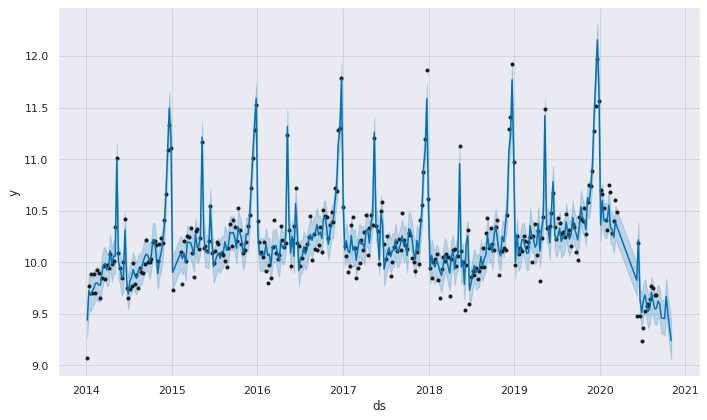

In [ ]:
 #Visualizando as previsões
 fig1 = modelo_otim.plot(forecast_sem)

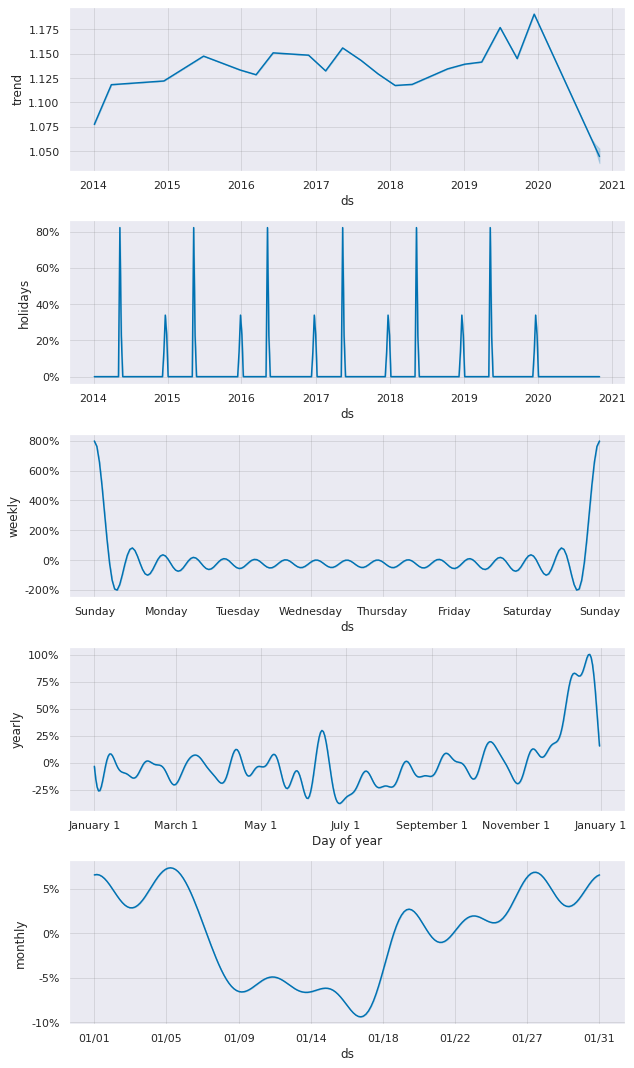

In [ ]:
#Visualizando os componentes
fig2 = modelo_otim.plot_components(forecast_sem)

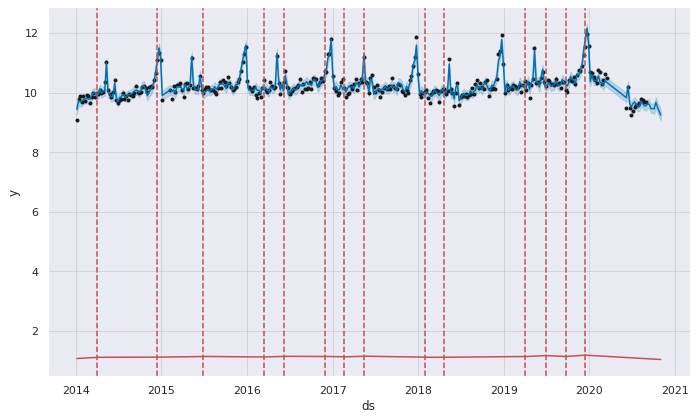

In [ ]:
#Visualização dos changepoints
fig3 = modelo_otim.plot(forecast_sem)
a = add_changepoints_to_plot(fig3.gca(), modelo_otim, forecast_sem)

# 7.0 Validação com os dados de teste

# 8.0 Tradução e interpretação do Erro

In [ ]:
dezembro = forecast[(forecast['ds']>='2020-12-01') & (forecast['ds']<='2020-12-31')]
dezembro
print('Previsão inferior de vendas: ',sum(np.expm1(dezembro.yhat_lower)))
print('Previsão de vendas: ',sum(np.expm1(dezembro.yhat)))
print('Previsão superior de vendas: ',sum(np.expm1(dezembro.yhat_upper)))

Previsão inferior de vendas:  0.0
Previsão de vendas:  0.0
Previsão superior de vendas:  0.0


In [ ]:
dez_19 = df5_pro[(df5_pro['ds']>'2019-12-02') & (df5_pro['ds']<='2019-12-31')]
dez_18 = df5_pro[(df5_pro['ds']>='2018-12-01') & (df5_pro['ds']<='2018-12-31')]
dez_17 = df5_pro[(df5_pro['ds']>='2017-12-01') & (df5_pro['ds']<='2017-12-31')]
print('19', sum(np.expm1(dez_19.y)))
print('18', sum(np.expm1(dez_18.y)))
print('17', sum(np.expm1(dez_17.y)))

19 435079.9699999888
18 370412.259999994
17 288811.50999999826


In [ ]:
dezembro.reset_index(inplace=True)
dez_19.reset_index(inplace=True)
dez_18.reset_index(inplace=True)
dez_17.reset_index(inplace=True)

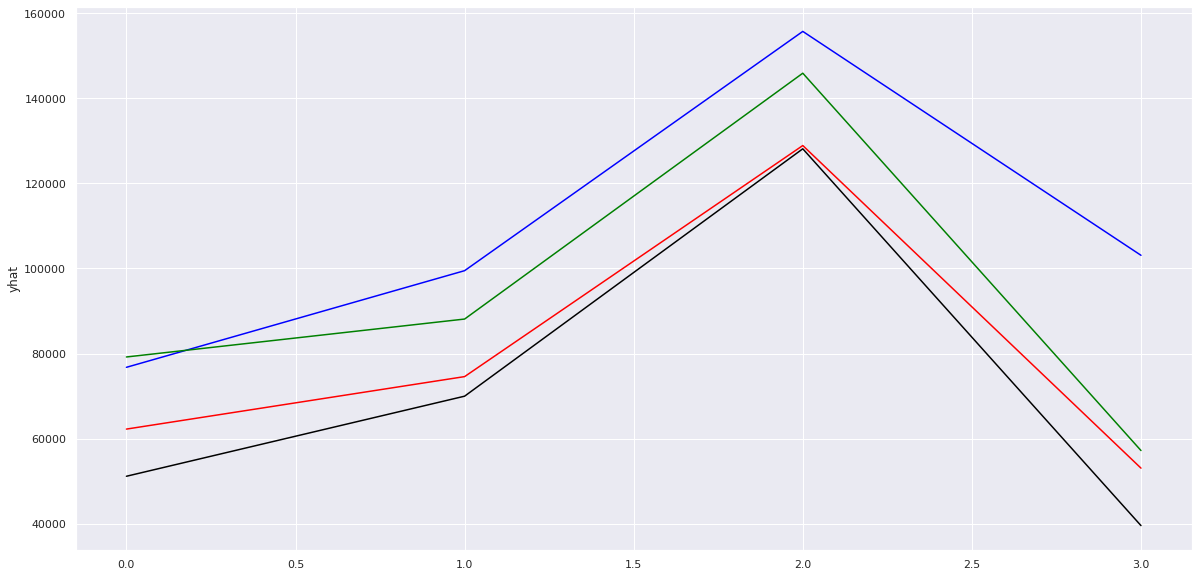

In [ ]:
sns.lineplot(x=dezembro.index, y=np.expm1(dezembro.yhat), color='red')
sns.lineplot(x=dez_19.index, y=np.expm1(dez_19.y), color='blue')
sns.lineplot(x=dez_18.index, y=np.expm1(dez_18.y), color='green')
sns.lineplot(x=dez_17.index, y=np.expm1(dez_17.y), color='black')